In [1]:
!pip install sentence-transformers

Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip install pandas

Defaulting to user installation because normal site-packages is not writeable


In [3]:


from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sentence_transformers import SentenceTransformer, InputExample, losses, models, datasets, evaluation
from torch.utils.data import DataLoader

from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np

import torch
import random
import torch

def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)

In [4]:
#Load the sprag dataset
data = pd.read_csv("refstdcombined.csv")
data.head(2)

,Unnamed: 0,QuestionID,ReferenceAnswer,StudentAnswer,Score1,Score2,avg_score,max_score
0,0.0,PythonQ001,"List, Set and Dictionary are mutable data stru...",Tha object structures which can be changeable ...,1.0,0.0,0.5,1.0
1,1.0,PythonQ001,"List, Set and Dictionary are mutable data stru...",Tuple,0.0,0.0,0.0,0.0


In [5]:
data['bin_score'] = data.apply(lambda row : 1 if row.avg_score>=3 else 0, axis=1)

In [6]:
data = data.dropna()

In [7]:
#### Just some code to print debug information to stdout
import logging
from sentence_transformers import LoggingHandler
logging.basicConfig(format='%(asctime)s - %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S',
                    level=logging.INFO,
                    handlers=[LoggingHandler()])

In [8]:
from sklearn.model_selection import train_test_split

# Storing labels in array
labels = data['bin_score'].values

# Dropping labels column from data
data = data.drop(['bin_score'], axis=1)

# Splitting data into train and test sets in a 70/30 ratio
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, random_state=42, test_size=0.2)

In [9]:
def sentence_pairs_generation(sentence1, sentence2, labels, pairs):
	# initialize two empty lists to hold the (sentence, sentence) pairs and
	# labels to indicate if the grade of the pair

  numClassesList = np.unique(labels)
  #print(numClassesList)
  idx = [np.where(labels == i)[0] for i in numClassesList]
  #print(idx)

  for idxA in range(len(sentence1)):      
    dAns = sentence1[idxA]
    sAns = sentence2[idxA]
    label = int(labels[idxA])
    
		  # prepare a pair and update the sentences and labels lists, respectively
    pairs.append(InputExample(texts=[dAns, sAns], label=label))

     
	# return a 2-tuple of our image pairs and labels
  return (pairs)

In [10]:
set_seed(0)
# Equal samples per class training
#train_df_sample = pd.concat([train_df[train_df[1]==0].sample(num_training), train_df[train_df[1]==1].sample(num_training)])
x_train_dA = train_data['ReferenceAnswer'].values.tolist()
x_train_sA = train_data['StudentAnswer'].values.tolist()
y_train = train_labels.tolist()
y_train = [int(x) for x in y_train]

In [11]:
#use test dataset as dev dataset
x_test_dA = test_data['ReferenceAnswer'].values.tolist()
x_test_sA = test_data['StudentAnswer'].values.tolist()
y_test = test_labels / 1.0
y_test = test_labels.tolist()
#y_test = [int(x) for x in y_test]

test_examples = [] 
test_examples = sentence_pairs_generation(np.array(x_test_dA), np.array(x_test_sA), np.array(y_test), test_examples)

In [12]:
train_examples = [] 
train_examples = sentence_pairs_generation(np.array(x_train_dA), np.array(x_train_sA), np.array(y_train), train_examples)

In [13]:
# Save path of the model
from datetime import datetime
model_save_path = 'output/training_sprag_v2_'+datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

In [15]:
from sentence_transformers import evaluation
import math

def train_and_evaluate(st_model, train_dataloader, test_dataloader, num_epochs,model_save_path):
  model = SentenceTransformer(st_model)
  #for evaluation
  train_loss = losses.SoftmaxLoss(model=model, sentence_embedding_dimension=model.get_sentence_embedding_dimension(), num_labels=6)
  test_evaluator = evaluation.LabelAccuracyEvaluator(test_dataloader, softmax_model=train_loss)

  #configuring the training
  warmup_steps = math.ceil(len(train_dataloader) * num_epochs * 0.1) #10% of train data for warm-up
  print(warmup_steps)
  #train_loss = losses.CosineSimilarityLoss(model)
  model.fit(train_objectives=[(train_dataloader, train_loss)],
          evaluator=test_evaluator,
          epochs=num_epochs,
          warmup_steps=warmup_steps,
          show_progress_bar=True,  
          #evaluation_steps=50, 
          output_path=model_save_path,)
  print("Training done...")

###Training - 1
#### stsb-distilbert-base

In [15]:
st_model = 'stsb-distilbert-base'
num_epochs = 10
batch_size=16
model_save_path = "binary_acc_output/"+st_model
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=batch_size)
  
test_dataloader = DataLoader(test_examples, shuffle=True, batch_size=batch_size)
model = train_and_evaluate(st_model, train_dataloader, test_dataloader, num_epochs, model_save_path)
print("\n\n")
print(" "*20, "*"*10, st_model , "*"*10)

# Load the stored model and evaluate its performance on mohler test dataset
model = SentenceTransformer(model_save_path)
train_loss = losses.SoftmaxLoss(model=model, sentence_embedding_dimension=model.get_sentence_embedding_dimension(), num_labels=6)
test_evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(test_examples, batch_size=16, name='SPRAG-test')
test_evaluator(model, output_path=model_save_path)
train_loss.cuda()

#training accuracy
print("\nTraining Accuracy")
te=evaluation.LabelAccuracyEvaluator(train_dataloader, softmax_model=train_loss)

te(model)

print("\nTest Accuracy")
te=evaluation.LabelAccuracyEvaluator(test_dataloader, softmax_model=train_loss)
te(model)

2022-07-18 19:16:31 - Load pretrained SentenceTransformer: stsb-distilbert-base
2022-07-18 19:16:32 - Use pytorch device: cuda
2022-07-18 19:16:32 - Softmax loss: #Vectors concatenated: 3
201


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 19:16:51 - Evaluation on the  dataset after epoch 0:
2022-07-18 19:16:52 - Accuracy: 0.7968 (639/802)

2022-07-18 19:16:52 - Save model to binary_acc_output/stsb-distilbert-base


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 19:17:09 - Evaluation on the  dataset after epoch 1:
2022-07-18 19:17:10 - Accuracy: 0.8354 (670/802)

2022-07-18 19:17:10 - Save model to binary_acc_output/stsb-distilbert-base


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 19:17:27 - Evaluation on the  dataset after epoch 2:
2022-07-18 19:17:28 - Accuracy: 0.8491 (681/802)

2022-07-18 19:17:28 - Save model to binary_acc_output/stsb-distilbert-base


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 19:17:45 - Evaluation on the  dataset after epoch 3:
2022-07-18 19:17:46 - Accuracy: 0.8441 (677/802)



Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 19:18:02 - Evaluation on the  dataset after epoch 4:
2022-07-18 19:18:04 - Accuracy: 0.8541 (685/802)

2022-07-18 19:18:04 - Save model to binary_acc_output/stsb-distilbert-base


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 19:18:20 - Evaluation on the  dataset after epoch 5:
2022-07-18 19:18:22 - Accuracy: 0.8516 (683/802)



Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 19:18:38 - Evaluation on the  dataset after epoch 6:
2022-07-18 19:18:39 - Accuracy: 0.8441 (677/802)



Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 19:18:55 - Evaluation on the  dataset after epoch 7:
2022-07-18 19:18:57 - Accuracy: 0.8479 (680/802)



Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 19:19:13 - Evaluation on the  dataset after epoch 8:
2022-07-18 19:19:14 - Accuracy: 0.8491 (681/802)



Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 19:19:30 - Evaluation on the  dataset after epoch 9:
2022-07-18 19:19:31 - Accuracy: 0.8479 (680/802)

Training done...



                     ********** stsb-distilbert-base **********
2022-07-18 19:19:31 - Load pretrained SentenceTransformer: binary_acc_output/stsb-distilbert-base
2022-07-18 19:19:32 - Use pytorch device: cuda
2022-07-18 19:19:32 - Softmax loss: #Vectors concatenated: 3
2022-07-18 19:19:32 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset:
2022-07-18 19:19:34 - Cosine-Similarity :	Pearson: 0.6848	Spearman: 0.6434
2022-07-18 19:19:34 - Manhattan-Distance:	Pearson: 0.6688	Spearman: 0.6428
2022-07-18 19:19:34 - Euclidean-Distance:	Pearson: 0.6722	Spearman: 0.6439
2022-07-18 19:19:34 - Dot-Product-Similarity:	Pearson: 0.6840	Spearman: 0.6407

Training Accuracy
2022-07-18 19:19:34 - Evaluation on the  dataset:
2022-07-18 19:19:39 - Accuracy: 0.4822 (1547/3208)


Test Accuracy
2022-07-18 19:19:39 - Evaluation on the  dataset:
2022-07-18

0.41271820448877805

### Experiment-2
####all-MiniLM-L6-v2

In [16]:
st_model = 'sentence-transformers/all-MiniLM-L6-v2'
num_epochs = 10
batch_size=16
model_save_path = "binary_acc_output/"+st_model
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=batch_size)
  
test_dataloader = DataLoader(test_examples, shuffle=True, batch_size=batch_size)
model = train_and_evaluate(st_model, train_dataloader, test_dataloader, num_epochs, model_save_path)
print("\n\n")
print(" "*20, "*"*10, st_model , "*"*10)

# Load the stored model and evaluate its performance on mohler test dataset
model = SentenceTransformer(model_save_path)
train_loss = losses.SoftmaxLoss(model=model, sentence_embedding_dimension=model.get_sentence_embedding_dimension(), num_labels=6)
test_evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(test_examples, batch_size=16, name='SPRAG-test')
test_evaluator(model, output_path=model_save_path)
train_loss.cuda()

#training accuracy
print("\nTraining Accuracy")
te=evaluation.LabelAccuracyEvaluator(train_dataloader, softmax_model=train_loss)

te(model)

print("\nTest Accuracy")
te=evaluation.LabelAccuracyEvaluator(test_dataloader, softmax_model=train_loss)
te(model)

2022-07-18 19:19:41 - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2022-07-18 19:19:41 - Use pytorch device: cuda
2022-07-18 19:19:41 - Softmax loss: #Vectors concatenated: 3
201


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 19:19:57 - Evaluation on the  dataset after epoch 0:
2022-07-18 19:19:58 - Accuracy: 0.6571 (527/802)

2022-07-18 19:19:58 - Save model to binary_acc_output/sentence-transformers/all-MiniLM-L6-v2


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 19:20:14 - Evaluation on the  dataset after epoch 1:
2022-07-18 19:20:15 - Accuracy: 0.7631 (612/802)

2022-07-18 19:20:15 - Save model to binary_acc_output/sentence-transformers/all-MiniLM-L6-v2


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 19:20:32 - Evaluation on the  dataset after epoch 2:
2022-07-18 19:20:33 - Accuracy: 0.7843 (629/802)

2022-07-18 19:20:33 - Save model to binary_acc_output/sentence-transformers/all-MiniLM-L6-v2


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 19:20:49 - Evaluation on the  dataset after epoch 3:
2022-07-18 19:20:50 - Accuracy: 0.7993 (641/802)

2022-07-18 19:20:50 - Save model to binary_acc_output/sentence-transformers/all-MiniLM-L6-v2


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 19:21:07 - Evaluation on the  dataset after epoch 4:
2022-07-18 19:21:08 - Accuracy: 0.8204 (658/802)

2022-07-18 19:21:08 - Save model to binary_acc_output/sentence-transformers/all-MiniLM-L6-v2


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 19:21:24 - Evaluation on the  dataset after epoch 5:
2022-07-18 19:21:25 - Accuracy: 0.8329 (668/802)

2022-07-18 19:21:25 - Save model to binary_acc_output/sentence-transformers/all-MiniLM-L6-v2


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 19:21:41 - Evaluation on the  dataset after epoch 6:
2022-07-18 19:21:42 - Accuracy: 0.8317 (667/802)



Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 19:21:58 - Evaluation on the  dataset after epoch 7:
2022-07-18 19:21:59 - Accuracy: 0.8317 (667/802)



Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 19:22:15 - Evaluation on the  dataset after epoch 8:
2022-07-18 19:22:16 - Accuracy: 0.8379 (672/802)

2022-07-18 19:22:16 - Save model to binary_acc_output/sentence-transformers/all-MiniLM-L6-v2


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 19:22:33 - Evaluation on the  dataset after epoch 9:
2022-07-18 19:22:34 - Accuracy: 0.8342 (669/802)

Training done...



                     ********** sentence-transformers/all-MiniLM-L6-v2 **********
2022-07-18 19:22:34 - Load pretrained SentenceTransformer: binary_acc_output/sentence-transformers/all-MiniLM-L6-v2
2022-07-18 19:22:34 - Use pytorch device: cuda
2022-07-18 19:22:34 - Softmax loss: #Vectors concatenated: 3
2022-07-18 19:22:34 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset:
2022-07-18 19:22:35 - Cosine-Similarity :	Pearson: 0.2287	Spearman: 0.2448
2022-07-18 19:22:35 - Manhattan-Distance:	Pearson: 0.2711	Spearman: 0.4561
2022-07-18 19:22:35 - Euclidean-Distance:	Pearson: 0.2040	Spearman: 0.2448
2022-07-18 19:22:35 - Dot-Product-Similarity:	Pearson: 0.2287	Spearman: 0.2448

Training Accuracy
2022-07-18 19:22:35 - Evaluation on the  dataset:
2022-07-18 19:22:40 - Accuracy: 0.0000 (0/3208)


Test Accuracy
2022-07-18 19:22:40 - Evalu

0.0

###Experiment-3
####multi-qa-MiniLM-L6-cos-v1

In [17]:
st_model = 'sentence-transformers/multi-qa-MiniLM-L6-cos-v1'
num_epochs = 10
batch_size=16
model_save_path = "binary_acc_output/"+st_model
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=batch_size)
  
test_dataloader = DataLoader(test_examples, shuffle=True, batch_size=batch_size)
model = train_and_evaluate(st_model, train_dataloader, test_dataloader, num_epochs, model_save_path)
print("\n\n")
print(" "*20, "*"*10, st_model , "*"*10)

# Load the stored model and evaluate its performance on mohler test dataset
model = SentenceTransformer(model_save_path)
train_loss = losses.SoftmaxLoss(model=model, sentence_embedding_dimension=model.get_sentence_embedding_dimension(), num_labels=6)
test_evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(test_examples, batch_size=16, name='SPRAG-test')
test_evaluator(model, output_path=model_save_path)
train_loss.cuda()

#training accuracy
print("\nTraining Accuracy")
te=evaluation.LabelAccuracyEvaluator(train_dataloader, softmax_model=train_loss)

te(model)

print("\nTest Accuracy")
te=evaluation.LabelAccuracyEvaluator(test_dataloader, softmax_model=train_loss)
te(model)

2022-07-18 19:22:41 - Load pretrained SentenceTransformer: sentence-transformers/multi-qa-MiniLM-L6-cos-v1
2022-07-18 19:22:42 - Use pytorch device: cuda
2022-07-18 19:22:42 - Softmax loss: #Vectors concatenated: 3
201


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 19:22:58 - Evaluation on the  dataset after epoch 0:
2022-07-18 19:22:59 - Accuracy: 0.6883 (552/802)

2022-07-18 19:22:59 - Save model to binary_acc_output/sentence-transformers/multi-qa-MiniLM-L6-cos-v1


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 19:23:15 - Evaluation on the  dataset after epoch 1:
2022-07-18 19:23:16 - Accuracy: 0.7494 (601/802)

2022-07-18 19:23:16 - Save model to binary_acc_output/sentence-transformers/multi-qa-MiniLM-L6-cos-v1


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 19:23:33 - Evaluation on the  dataset after epoch 2:
2022-07-18 19:23:34 - Accuracy: 0.7880 (632/802)

2022-07-18 19:23:34 - Save model to binary_acc_output/sentence-transformers/multi-qa-MiniLM-L6-cos-v1


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 19:23:50 - Evaluation on the  dataset after epoch 3:
2022-07-18 19:23:51 - Accuracy: 0.8080 (648/802)

2022-07-18 19:23:51 - Save model to binary_acc_output/sentence-transformers/multi-qa-MiniLM-L6-cos-v1


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 19:24:08 - Evaluation on the  dataset after epoch 4:
2022-07-18 19:24:09 - Accuracy: 0.8130 (652/802)

2022-07-18 19:24:09 - Save model to binary_acc_output/sentence-transformers/multi-qa-MiniLM-L6-cos-v1


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 19:24:24 - Evaluation on the  dataset after epoch 5:
2022-07-18 19:24:25 - Accuracy: 0.8204 (658/802)

2022-07-18 19:24:25 - Save model to binary_acc_output/sentence-transformers/multi-qa-MiniLM-L6-cos-v1


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 19:24:42 - Evaluation on the  dataset after epoch 6:
2022-07-18 19:24:43 - Accuracy: 0.8441 (677/802)

2022-07-18 19:24:43 - Save model to binary_acc_output/sentence-transformers/multi-qa-MiniLM-L6-cos-v1


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 19:24:59 - Evaluation on the  dataset after epoch 7:
2022-07-18 19:25:00 - Accuracy: 0.8304 (666/802)



Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 19:25:16 - Evaluation on the  dataset after epoch 8:
2022-07-18 19:25:17 - Accuracy: 0.8342 (669/802)



Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 19:25:33 - Evaluation on the  dataset after epoch 9:
2022-07-18 19:25:35 - Accuracy: 0.8354 (670/802)

Training done...



                     ********** sentence-transformers/multi-qa-MiniLM-L6-cos-v1 **********
2022-07-18 19:25:35 - Load pretrained SentenceTransformer: binary_acc_output/sentence-transformers/multi-qa-MiniLM-L6-cos-v1
2022-07-18 19:25:35 - Use pytorch device: cuda
2022-07-18 19:25:35 - Softmax loss: #Vectors concatenated: 3
2022-07-18 19:25:35 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset:
2022-07-18 19:25:36 - Cosine-Similarity :	Pearson: 0.1719	Spearman: 0.0713
2022-07-18 19:25:36 - Manhattan-Distance:	Pearson: 0.2155	Spearman: 0.2982
2022-07-18 19:25:36 - Euclidean-Distance:	Pearson: 0.1745	Spearman: 0.0713
2022-07-18 19:25:36 - Dot-Product-Similarity:	Pearson: 0.1719	Spearman: 0.0713

Training Accuracy
2022-07-18 19:25:36 - Evaluation on the  dataset:
2022-07-18 19:25:41 - Accuracy: 0.0009 (3/3208)


Test Accuracy
2022-07-1

0.0012468827930174563

### Experiment-4
####paraphrase-MiniLM-L6-v2

In [18]:
st_model = 'sentence-transformers/paraphrase-MiniLM-L6-v2'
num_epochs = 10
batch_size=16
model_save_path = "binary_acc_output/"+st_model
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=batch_size)
  
test_dataloader = DataLoader(test_examples, shuffle=True, batch_size=batch_size)
model = train_and_evaluate(st_model, train_dataloader, test_dataloader, num_epochs, model_save_path)
print("\n\n")
print(" "*20, "*"*10, st_model , "*"*10)

# Load the stored model and evaluate its performance on mohler test dataset
model = SentenceTransformer(model_save_path)
train_loss = losses.SoftmaxLoss(model=model, sentence_embedding_dimension=model.get_sentence_embedding_dimension(), num_labels=6)
test_evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(test_examples, batch_size=16, name='SPRAG-test')
test_evaluator(model, output_path=model_save_path)
train_loss.cuda()

#training accuracy
print("\nTraining Accuracy")
te=evaluation.LabelAccuracyEvaluator(train_dataloader, softmax_model=train_loss)

te(model)

print("\nTest Accuracy")
te=evaluation.LabelAccuracyEvaluator(test_dataloader, softmax_model=train_loss)
te(model)

2022-07-18 19:25:58 - Load pretrained SentenceTransformer: sentence-transformers/paraphrase-MiniLM-L6-v2
2022-07-18 19:25:58 - Use pytorch device: cuda
2022-07-18 19:25:58 - Softmax loss: #Vectors concatenated: 3
201


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 19:26:14 - Evaluation on the  dataset after epoch 0:
2022-07-18 19:26:15 - Accuracy: 0.7643 (613/802)

2022-07-18 19:26:15 - Save model to binary_acc_output/sentence-transformers/paraphrase-MiniLM-L6-v2


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 19:26:32 - Evaluation on the  dataset after epoch 1:
2022-07-18 19:26:33 - Accuracy: 0.8267 (663/802)

2022-07-18 19:26:33 - Save model to binary_acc_output/sentence-transformers/paraphrase-MiniLM-L6-v2


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 19:26:49 - Evaluation on the  dataset after epoch 2:
2022-07-18 19:26:50 - Accuracy: 0.8354 (670/802)

2022-07-18 19:26:50 - Save model to binary_acc_output/sentence-transformers/paraphrase-MiniLM-L6-v2


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 19:27:06 - Evaluation on the  dataset after epoch 3:
2022-07-18 19:27:07 - Accuracy: 0.8416 (675/802)

2022-07-18 19:27:07 - Save model to binary_acc_output/sentence-transformers/paraphrase-MiniLM-L6-v2


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 19:27:24 - Evaluation on the  dataset after epoch 4:
2022-07-18 19:27:25 - Accuracy: 0.8454 (678/802)

2022-07-18 19:27:25 - Save model to binary_acc_output/sentence-transformers/paraphrase-MiniLM-L6-v2


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 19:27:41 - Evaluation on the  dataset after epoch 5:
2022-07-18 19:27:42 - Accuracy: 0.8516 (683/802)

2022-07-18 19:27:42 - Save model to binary_acc_output/sentence-transformers/paraphrase-MiniLM-L6-v2


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 19:27:58 - Evaluation on the  dataset after epoch 6:
2022-07-18 19:27:59 - Accuracy: 0.8466 (679/802)



Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 19:28:15 - Evaluation on the  dataset after epoch 7:
2022-07-18 19:28:16 - Accuracy: 0.8504 (682/802)



Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 19:28:32 - Evaluation on the  dataset after epoch 8:
2022-07-18 19:28:33 - Accuracy: 0.8454 (678/802)



Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 19:28:49 - Evaluation on the  dataset after epoch 9:
2022-07-18 19:28:50 - Accuracy: 0.8491 (681/802)

Training done...



                     ********** sentence-transformers/paraphrase-MiniLM-L6-v2 **********
2022-07-18 19:28:50 - Load pretrained SentenceTransformer: binary_acc_output/sentence-transformers/paraphrase-MiniLM-L6-v2
2022-07-18 19:28:50 - Use pytorch device: cuda
2022-07-18 19:28:50 - Softmax loss: #Vectors concatenated: 3
2022-07-18 19:28:50 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset:
2022-07-18 19:28:52 - Cosine-Similarity :	Pearson: 0.6675	Spearman: 0.6286
2022-07-18 19:28:52 - Manhattan-Distance:	Pearson: 0.6695	Spearman: 0.6277
2022-07-18 19:28:52 - Euclidean-Distance:	Pearson: 0.6714	Spearman: 0.6282
2022-07-18 19:28:52 - Dot-Product-Similarity:	Pearson: 0.6680	Spearman: 0.6262

Training Accuracy
2022-07-18 19:28:52 - Evaluation on the  dataset:
2022-07-18 19:28:56 - Accuracy: 0.0542 (174/3208)


Test Accuracy
2022-07-18 

0.06234413965087282

###Experiment-5
####paraphrase-albert-small-v2

In [19]:
st_model = 'sentence-transformers/paraphrase-albert-small-v2'
num_epochs = 10
batch_size=16
model_save_path = "binary_acc_output/"+st_model
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=batch_size)
  
test_dataloader = DataLoader(test_examples, shuffle=True, batch_size=batch_size)
model = train_and_evaluate(st_model, train_dataloader, test_dataloader, num_epochs, model_save_path)
print("\n\n")
print(" "*20, "*"*10, st_model , "*"*10)

# Load the stored model and evaluate its performance on mohler test dataset
model = SentenceTransformer(model_save_path)
train_loss = losses.SoftmaxLoss(model=model, sentence_embedding_dimension=model.get_sentence_embedding_dimension(), num_labels=6)
test_evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(test_examples, batch_size=16, name='SPRAG-test')
test_evaluator(model, output_path=model_save_path)
train_loss.cuda()

#training accuracy
print("\nTraining Accuracy")
te=evaluation.LabelAccuracyEvaluator(train_dataloader, softmax_model=train_loss)

te(model)

print("\nTest Accuracy")
te=evaluation.LabelAccuracyEvaluator(test_dataloader, softmax_model=train_loss)
te(model)

2022-07-18 19:29:23 - Load pretrained SentenceTransformer: sentence-transformers/paraphrase-albert-small-v2
2022-07-18 19:29:23 - Use pytorch device: cuda
2022-07-18 19:29:23 - Softmax loss: #Vectors concatenated: 3
201


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 19:29:39 - Evaluation on the  dataset after epoch 0:
2022-07-18 19:29:40 - Accuracy: 0.7681 (616/802)

2022-07-18 19:29:40 - Save model to binary_acc_output/sentence-transformers/paraphrase-albert-small-v2


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 19:29:55 - Evaluation on the  dataset after epoch 1:
2022-07-18 19:29:57 - Accuracy: 0.8329 (668/802)

2022-07-18 19:29:57 - Save model to binary_acc_output/sentence-transformers/paraphrase-albert-small-v2


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 19:30:12 - Evaluation on the  dataset after epoch 2:
2022-07-18 19:30:14 - Accuracy: 0.8454 (678/802)

2022-07-18 19:30:14 - Save model to binary_acc_output/sentence-transformers/paraphrase-albert-small-v2


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 19:30:29 - Evaluation on the  dataset after epoch 3:
2022-07-18 19:30:30 - Accuracy: 0.8404 (674/802)



Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 19:30:45 - Evaluation on the  dataset after epoch 4:
2022-07-18 19:30:47 - Accuracy: 0.8466 (679/802)

2022-07-18 19:30:47 - Save model to binary_acc_output/sentence-transformers/paraphrase-albert-small-v2


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 19:31:02 - Evaluation on the  dataset after epoch 5:
2022-07-18 19:31:04 - Accuracy: 0.8603 (690/802)

2022-07-18 19:31:04 - Save model to binary_acc_output/sentence-transformers/paraphrase-albert-small-v2


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 19:31:19 - Evaluation on the  dataset after epoch 6:
2022-07-18 19:31:20 - Accuracy: 0.8404 (674/802)



Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 19:31:35 - Evaluation on the  dataset after epoch 7:
2022-07-18 19:31:37 - Accuracy: 0.8554 (686/802)



Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 19:31:52 - Evaluation on the  dataset after epoch 8:
2022-07-18 19:31:54 - Accuracy: 0.8529 (684/802)



Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 19:32:09 - Evaluation on the  dataset after epoch 9:
2022-07-18 19:32:10 - Accuracy: 0.8504 (682/802)

Training done...



                     ********** sentence-transformers/paraphrase-albert-small-v2 **********
2022-07-18 19:32:10 - Load pretrained SentenceTransformer: binary_acc_output/sentence-transformers/paraphrase-albert-small-v2
2022-07-18 19:32:10 - Use pytorch device: cuda
2022-07-18 19:32:10 - Softmax loss: #Vectors concatenated: 3
2022-07-18 19:32:10 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset:
2022-07-18 19:32:12 - Cosine-Similarity :	Pearson: 0.7036	Spearman: 0.6756
2022-07-18 19:32:12 - Manhattan-Distance:	Pearson: 0.6752	Spearman: 0.6744
2022-07-18 19:32:12 - Euclidean-Distance:	Pearson: 0.6779	Spearman: 0.6754
2022-07-18 19:32:12 - Dot-Product-Similarity:	Pearson: 0.6985	Spearman: 0.6693

Training Accuracy
2022-07-18 19:32:12 - Evaluation on the  dataset:
2022-07-18 19:32:18 - Accuracy: 0.0617 (198/3208)


Test Accuracy
2022-

0.08977556109725686

###Experiment-6
####stsb-roberta-largenum_epochs = 1


In [20]:
torch.cuda.empty_cache()

In [21]:
st_model = 'sentence-transformers/stsb-roberta-large'
num_epochs = 10
batch_size=16
model_save_path = "binary_acc_output/"+st_model
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=batch_size)
  
test_dataloader = DataLoader(test_examples, shuffle=True, batch_size=batch_size)
model = train_and_evaluate(st_model, train_dataloader, test_dataloader, num_epochs, model_save_path)
print("\n\n")
print(" "*20, "*"*10, st_model , "*"*10)

# Load the stored model and evaluate its performance on mohler test dataset
model = SentenceTransformer(model_save_path)
train_loss = losses.SoftmaxLoss(model=model, sentence_embedding_dimension=model.get_sentence_embedding_dimension(), num_labels=6)
test_evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(test_examples, batch_size=16, name='SPRAG-test')
test_evaluator(model, output_path=model_save_path)
train_loss.cuda()

#training accuracy
print("\nTraining Accuracy")
te=evaluation.LabelAccuracyEvaluator(train_dataloader, softmax_model=train_loss)

te(model)

print("\nTest Accuracy")
te=evaluation.LabelAccuracyEvaluator(test_dataloader, softmax_model=train_loss)
te(model)

2022-07-18 19:32:45 - Load pretrained SentenceTransformer: sentence-transformers/stsb-roberta-large
2022-07-18 19:32:49 - Use pytorch device: cuda
2022-07-18 19:32:49 - Softmax loss: #Vectors concatenated: 3
201


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 19:34:26 - Evaluation on the  dataset after epoch 0:
2022-07-18 19:34:33 - Accuracy: 0.8155 (654/802)

2022-07-18 19:34:33 - Save model to binary_acc_output/sentence-transformers/stsb-roberta-large


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 19:36:12 - Evaluation on the  dataset after epoch 1:
2022-07-18 19:36:18 - Accuracy: 0.8329 (668/802)

2022-07-18 19:36:18 - Save model to binary_acc_output/sentence-transformers/stsb-roberta-large


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 19:37:58 - Evaluation on the  dataset after epoch 2:
2022-07-18 19:38:05 - Accuracy: 0.8030 (644/802)



Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 19:39:40 - Evaluation on the  dataset after epoch 3:
2022-07-18 19:39:47 - Accuracy: 0.8441 (677/802)

2022-07-18 19:39:47 - Save model to binary_acc_output/sentence-transformers/stsb-roberta-large


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 19:41:26 - Evaluation on the  dataset after epoch 4:
2022-07-18 19:41:33 - Accuracy: 0.8317 (667/802)



Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 19:43:10 - Evaluation on the  dataset after epoch 5:
2022-07-18 19:43:16 - Accuracy: 0.8429 (676/802)



Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 19:44:52 - Evaluation on the  dataset after epoch 6:
2022-07-18 19:44:59 - Accuracy: 0.8304 (666/802)



Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 19:46:36 - Evaluation on the  dataset after epoch 7:
2022-07-18 19:46:42 - Accuracy: 0.8416 (675/802)



Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 19:48:19 - Evaluation on the  dataset after epoch 8:
2022-07-18 19:48:26 - Accuracy: 0.8379 (672/802)



Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 19:50:02 - Evaluation on the  dataset after epoch 9:
2022-07-18 19:50:09 - Accuracy: 0.8404 (674/802)

Training done...



                     ********** sentence-transformers/stsb-roberta-large **********
2022-07-18 19:50:09 - Load pretrained SentenceTransformer: binary_acc_output/sentence-transformers/stsb-roberta-large
2022-07-18 19:50:12 - Use pytorch device: cuda
2022-07-18 19:50:12 - Softmax loss: #Vectors concatenated: 3
2022-07-18 19:50:12 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset:
2022-07-18 19:50:17 - Cosine-Similarity :	Pearson: 0.6769	Spearman: 0.6581
2022-07-18 19:50:17 - Manhattan-Distance:	Pearson: 0.6546	Spearman: 0.6535
2022-07-18 19:50:17 - Euclidean-Distance:	Pearson: 0.6583	Spearman: 0.6576
2022-07-18 19:50:17 - Dot-Product-Similarity:	Pearson: 0.6775	Spearman: 0.6552

Training Accuracy
2022-07-18 19:50:17 - Evaluation on the  dataset:
2022-07-18 19:50:45 - Accuracy: 0.0377 (121/3208)


Test Accuracy
2022-07-18 19:50:45 -

0.04987531172069826

###Experiment-7
####nli-bert-large-cls-pooling

In [16]:
st_model = 'sentence-transformers/nli-bert-large-cls-pooling'
num_epochs = 10
batch_size=16
model_save_path = "binary_acc_output/"+st_model
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=batch_size)
  
test_dataloader = DataLoader(test_examples, shuffle=True, batch_size=batch_size)
model = train_and_evaluate(st_model, train_dataloader, test_dataloader, num_epochs, model_save_path)
print("\n\n")
print(" "*20, "*"*10, st_model , "*"*10)

# Load the stored model and evaluate its performance on mohler test dataset
model = SentenceTransformer(model_save_path)
train_loss = losses.SoftmaxLoss(model=model, sentence_embedding_dimension=model.get_sentence_embedding_dimension(), num_labels=6)
test_evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(test_examples, batch_size=16, name='SPRAG-test')
test_evaluator(model, output_path=model_save_path)
train_loss.cuda()

#training accuracy
print("\nTraining Accuracy")
te=evaluation.LabelAccuracyEvaluator(train_dataloader, softmax_model=train_loss)

te(model)

print("\nTest Accuracy")
te=evaluation.LabelAccuracyEvaluator(test_dataloader, softmax_model=train_loss)
te(model)

2022-07-18 19:54:52 - Load pretrained SentenceTransformer: sentence-transformers/nli-bert-large-cls-pooling
2022-07-18 19:54:56 - Use pytorch device: cuda
2022-07-18 19:54:56 - Softmax loss: #Vectors concatenated: 3
201


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 19:56:32 - Evaluation on the  dataset after epoch 0:
2022-07-18 19:56:39 - Accuracy: 0.8055 (646/802)

2022-07-18 19:56:39 - Save model to binary_acc_output/sentence-transformers/nli-bert-large-cls-pooling


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 19:58:15 - Evaluation on the  dataset after epoch 1:
2022-07-18 19:58:21 - Accuracy: 0.8479 (680/802)

2022-07-18 19:58:21 - Save model to binary_acc_output/sentence-transformers/nli-bert-large-cls-pooling


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 19:59:57 - Evaluation on the  dataset after epoch 2:
2022-07-18 20:00:04 - Accuracy: 0.8603 (690/802)

2022-07-18 20:00:04 - Save model to binary_acc_output/sentence-transformers/nli-bert-large-cls-pooling


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 20:01:40 - Evaluation on the  dataset after epoch 3:
2022-07-18 20:01:47 - Accuracy: 0.8591 (689/802)



Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 20:03:19 - Evaluation on the  dataset after epoch 4:
2022-07-18 20:03:26 - Accuracy: 0.8591 (689/802)



Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 20:04:59 - Evaluation on the  dataset after epoch 5:
2022-07-18 20:05:06 - Accuracy: 0.8516 (683/802)



Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 20:06:39 - Evaluation on the  dataset after epoch 6:
2022-07-18 20:06:45 - Accuracy: 0.8541 (685/802)



Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 20:08:19 - Evaluation on the  dataset after epoch 7:
2022-07-18 20:08:26 - Accuracy: 0.8566 (687/802)



Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 20:09:59 - Evaluation on the  dataset after epoch 8:
2022-07-18 20:10:05 - Accuracy: 0.8616 (691/802)

2022-07-18 20:10:05 - Save model to binary_acc_output/sentence-transformers/nli-bert-large-cls-pooling


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 20:11:42 - Evaluation on the  dataset after epoch 9:
2022-07-18 20:11:49 - Accuracy: 0.8591 (689/802)

Training done...



                     ********** sentence-transformers/nli-bert-large-cls-pooling **********
2022-07-18 20:11:49 - Load pretrained SentenceTransformer: binary_acc_output/sentence-transformers/nli-bert-large-cls-pooling
2022-07-18 20:11:52 - Use pytorch device: cuda
2022-07-18 20:11:52 - Softmax loss: #Vectors concatenated: 3
2022-07-18 20:11:52 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset:
2022-07-18 20:11:57 - Cosine-Similarity :	Pearson: 0.7421	Spearman: 0.6808
2022-07-18 20:11:57 - Manhattan-Distance:	Pearson: 0.7241	Spearman: 0.6798
2022-07-18 20:11:57 - Euclidean-Distance:	Pearson: 0.7261	Spearman: 0.6806
2022-07-18 20:11:57 - Dot-Product-Similarity:	Pearson: 0.7420	Spearman: 0.6805

Training Accuracy
2022-07-18 20:11:57 - Evaluation on the  dataset:
2022-07-18 20:12:24 - Accuracy: 0.0181 (58/3208)


Test Accuracy
2022-0

0.11221945137157108

###Experiment-8
####quora-distilbert-base

In [17]:
st_model = 'sentence-transformers/quora-distilbert-base'
num_epochs = 10
batch_size=16
model_save_path = "binary_acc_output/"+st_model
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=batch_size)
  
test_dataloader = DataLoader(test_examples, shuffle=True, batch_size=batch_size)
model = train_and_evaluate(st_model, train_dataloader, test_dataloader, num_epochs, model_save_path)
print("\n\n")
print(" "*20, "*"*10, st_model , "*"*10)

# Load the stored model and evaluate its performance on mohler test dataset
model = SentenceTransformer(model_save_path)
train_loss = losses.SoftmaxLoss(model=model, sentence_embedding_dimension=model.get_sentence_embedding_dimension(), num_labels=6)
test_evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(test_examples, batch_size=16, name='SPRAG-test')
test_evaluator(model, output_path=model_save_path)
train_loss.cuda()

#training accuracy
print("\nTraining Accuracy")
te=evaluation.LabelAccuracyEvaluator(train_dataloader, softmax_model=train_loss)

te(model)

print("\nTest Accuracy")
te=evaluation.LabelAccuracyEvaluator(test_dataloader, softmax_model=train_loss)
te(model)

2022-07-18 20:13:37 - Load pretrained SentenceTransformer: sentence-transformers/quora-distilbert-base
2022-07-18 20:13:38 - Use pytorch device: cuda
2022-07-18 20:13:38 - Softmax loss: #Vectors concatenated: 3
201


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 20:13:54 - Evaluation on the  dataset after epoch 0:
2022-07-18 20:13:56 - Accuracy: 0.8067 (647/802)

2022-07-18 20:13:56 - Save model to binary_acc_output/sentence-transformers/quora-distilbert-base


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 20:14:12 - Evaluation on the  dataset after epoch 1:
2022-07-18 20:14:14 - Accuracy: 0.8466 (679/802)

2022-07-18 20:14:14 - Save model to binary_acc_output/sentence-transformers/quora-distilbert-base


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 20:14:31 - Evaluation on the  dataset after epoch 2:
2022-07-18 20:14:32 - Accuracy: 0.8491 (681/802)

2022-07-18 20:14:32 - Save model to binary_acc_output/sentence-transformers/quora-distilbert-base


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 20:14:49 - Evaluation on the  dataset after epoch 3:
2022-07-18 20:14:50 - Accuracy: 0.8354 (670/802)



Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 20:15:06 - Evaluation on the  dataset after epoch 4:
2022-07-18 20:15:07 - Accuracy: 0.8354 (670/802)



Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 20:15:23 - Evaluation on the  dataset after epoch 5:
2022-07-18 20:15:25 - Accuracy: 0.8392 (673/802)



Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 20:15:41 - Evaluation on the  dataset after epoch 6:
2022-07-18 20:15:43 - Accuracy: 0.8416 (675/802)



Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 20:15:59 - Evaluation on the  dataset after epoch 7:
2022-07-18 20:16:00 - Accuracy: 0.8454 (678/802)



Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 20:16:16 - Evaluation on the  dataset after epoch 8:
2022-07-18 20:16:17 - Accuracy: 0.8429 (676/802)



Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 20:16:33 - Evaluation on the  dataset after epoch 9:
2022-07-18 20:16:35 - Accuracy: 0.8479 (680/802)

Training done...



                     ********** sentence-transformers/quora-distilbert-base **********
2022-07-18 20:16:35 - Load pretrained SentenceTransformer: binary_acc_output/sentence-transformers/quora-distilbert-base
2022-07-18 20:16:35 - Use pytorch device: cuda
2022-07-18 20:16:35 - Softmax loss: #Vectors concatenated: 3
2022-07-18 20:16:35 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset:
2022-07-18 20:16:37 - Cosine-Similarity :	Pearson: 0.6833	Spearman: 0.6588
2022-07-18 20:16:37 - Manhattan-Distance:	Pearson: 0.6610	Spearman: 0.6543
2022-07-18 20:16:37 - Euclidean-Distance:	Pearson: 0.6650	Spearman: 0.6559
2022-07-18 20:16:37 - Dot-Product-Similarity:	Pearson: 0.6883	Spearman: 0.6593

Training Accuracy
2022-07-18 20:16:37 - Evaluation on the  dataset:
2022-07-18 20:16:42 - Accuracy: 0.3017 (968/3208)


Test Accuracy
2022-07-18 20:1

0.33915211970074816

In [25]:
sentences = ["A function is a  reusable block of code that is intended to perform a single and specific task",
            "A function is a block of code written in python which is  reusable as many times .",
            "It can defined by keyword def function_name(argu):",
            "A block of code that can used over and over again with different values.",
            "It is a group of code. Set of   statements  runs whenever called",
            "A function is a block of instructions that takes input and process it then return the output.",
            "Function is used to perform specific task.",
            "Block of code perform a specific task",
            "Function is a block of code. It contains code for particular function . These are very useful for complex problems ",
            "A function is a resuable block of code that can perform basic task"]


In [26]:
import numpy as np
from sentence_transformers.util import cos_sim
# build embeddings and calculate cosine similarity
def sts_process(sentence_a, sentence_b, model):
    vecs = []  # init list of sentence vecs
    for sentence in [sentence_a, sentence_b]:
        # build input_ids and attention_mask tensors with tokenizer
        input_ids = tokenizer(
            sentence, max_length=128, padding='max_length',
            truncation=True, return_tensors='pt'
        )
        # process tokens through model and extract token embeddings
        token_embeds = model(**input_ids).last_hidden_state
        # mean-pool token embeddings to create sentence embeddings
        sentence_embeds = mean_pool(token_embeds, input_ids['attention_mask'])
        vecs.append(sentence_embeds)
    # calculate cosine similarity between pairs and return numpy array
    return cos_sim(vecs[0], vecs[1]).detach().numpy()

# controller function to build similarity matrix
def sim_matrix(model):
    # initialize empty zeros array to store similarity scores
    sim = np.zeros((len(sentences), len(sentences)))
    for i in range(len(sentences)):
        # add similarity scores to the similarity matrix
        sim[i:,i] = sts_process(sentences[i], sentences[i:], model)
    return sim

In [27]:
# define mean pooling function
def mean_pool(token_embeds, attention_mask):
    # reshape attention_mask to cover 768-dimension embeddings
    in_mask = attention_mask.unsqueeze(-1).expand(
        token_embeds.size()
    ).float()
    # perform mean-pooling but exclude padding tokens (specified by in_mask)
    pool = torch.sum(token_embeds * in_mask, 1) / torch.clamp(
        in_mask.sum(1), min=1e-9
    )
    return pool

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModel


tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/stsb-distilbert-large')
model = AutoModel.from_pretrained('./output/sentence-transformers/stsb-distilbert-large')

sim = sim_matrix(model)  # build similarity scores matrix
# visualize heatmap
mask = np.zeros_like(sim)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(10, 7))
    ax = sns.heatmap(sim, annot=True, mask=mask, vmax=.5, square=True)

OSError: sentence-transformers/stsb-distilbert-large is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo with `use_auth_token` or log in with `huggingface-cli login` and pass `use_auth_token=True`.

Downloading:   0%|          | 0.00/489 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/539 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

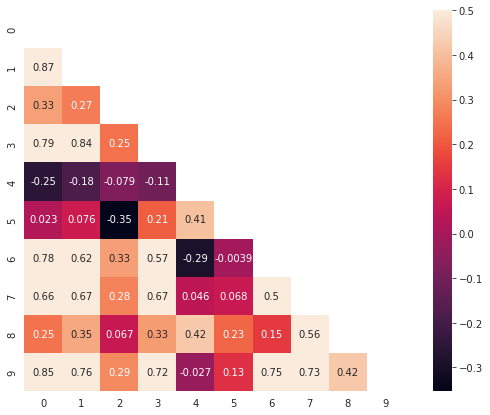

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModel


tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/stsb-distilbert-base')
model = AutoModel.from_pretrained('./output/stsb-distilbert-base')

sim = sim_matrix(model)  # build similarity scores matrix
# visualize heatmap
mask = np.zeros_like(sim)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(10, 7))
    ax = sns.heatmap(sim, annot=True, mask=mask, vmax=.5, square=True)